# 7. Stellar Mass black Holes in an AGN accretion disk

As explained in the lecture, the integration of particle paths is on the one hand a non-trivial issue, in that one must be careful when choosing the method of integration, so particles don't lose or gain energy for purely numerical reasons. On the other hand there does exist a simple and robust method; the kick-drift-kick (KDK) method, which is good enough for most practical purposes, except maybe longterm integration of planetary orbits.

### Overview
The purpose of this exercise is to play around with a particle integrator and build a model for how stellar mass black holes migrate in the accretion disk of a super massive black hole (SMBH).

### Setup
This notebook initialises `n` particles in the central potential of the SMBH. The particle orbits have radii `rad` with some normal distributed distribution with std dev `dispersion` and an `eccentricity` (0 for circular, 1 for direct infall) with a normal distributed spread `edispersion` centered on ``e=0``. Since normal distributed variables can have arbitrarily large positive and negative values around the mean we limit the radial distribution to the interval `[rmin, rmax]`and the eccentricity to be below `emax`.

### The Kepler problem
The Kepler problem is a simplified two-body problem, where one of the bodies is a mass-less test particle. The motion is characterised by the two constants of motion. The specific (per mass) energy is:

\begin{equation}
E = {1 \over 2} v^2 - {GM \over r}
\end{equation}
and the specific (per mass) angular momentum is
\begin{equation}
L = r \times v
\end{equation}
The acceleration of the test particle is given from Newton's law of gravitation

\begin{equation}
\mathbf{a} = - \frac{GM}{r^2} \frac{\mathbf{r}}{r}
\end{equation}
For the special case of circular motion we have
\begin{equation}
v_\textrm{circle} = v_\textrm{Kepler} = \sqrt{\frac{GM}{r}}
\end{equation}
and the specific energy is $E_\textrm{circle} = - {1 \over 2} {GM \over r}$.

In the general case the orbit is an ellipse. The eccentricity of the ellipse can be caluculated from the specific energy and angular momentum as
\begin{equation}
e = \sqrt{1 + \frac{2 E L^2}{(GM)^2}}
\end{equation}
the orbit period $P$ and the semi-major axis $a$ are related to the specific energy as

\begin{align}
E  & = - {1 \over 2} {GM \over a} \\
P^2 & = \frac{4\pi^2}{GM} a^3
\end{align}

If the specific energy is positive, the particle is unbound.

These few key equations a enough to setup a simple Kepler problem with a given eccentricity and radius as done below. You can read more about the two-body problem in chapter 3.3 of the book.

### Preparations:
1. Review what the issues are, by reading Chapter 3 and/or the slide deck. Apart from secular (slow and systematic) changes in total energy, there are also other types of errors.  Paths that should be exactly elliptic can have nutation, for example, where the aphelion / perihelion positions rotate a small amount for each orbit. Such a path is typically also associated with a variation of total energy along the path so that, even though energy is conserved over full orbits, it is not conserved exactly during one orbit. Examples of that are in the slides, and you will also create your own below.

2. _Take your time_ to review the comments in the subroutines below. If you do not understand what the purpose of an option is, please ask.

3. Below the two class definitions is a small example of how to use the setup. With a low number of particles, the time, position, and velocity of each particle is stored as a function of time, and a few statistics and orbital plots are made. This will help you understand the behaviour of the integrator with different sets of options.

In [37]:
import numpy as np                      # Import numpy
import numba as nb                      # Import numba
import matplotlib.pyplot as plt         # Import pyplot from matplotlib
from time import time                   # Import time procedure for timing measurement
from scipy.interpolate import UnivariateSpline
np.set_printoptions(linewidth=120)      # Expand the nr of columns used for printing
np.seterr(invalid='raise');             # Fail the code if any exception is raised 

### Gravitational Units
We will use "gravitational" units tailored for the super massive black hole (SMBH) where
\begin{align}
[Mass]   &= \textrm{Mass of SMBH} \\
[Length] &= \textrm{Gravitational radius of SMBH} = R_g = \frac{2 GM_{SMBH}}{c^2} \\
[Velocity] &= c \\
[Time]   &= \frac{R_g}{c}
\end{align}
The units for $GM$ is $[Length]^3 / [Time]^2$ which is
\begin{equation}
[GM] = \frac{Length]^3}{Time]^2} = \frac{R_g^3}{(R_g / c)^2} = c^2 R_g = 2 GM_{SMBH}
\end{equation}
We therefore have that for a general mass:
\begin{equation}
G M = G M_{SMBH} (M / M_{SMBH}) = 2 M_{code}
\end{equation}

In [38]:
# GM is a global variable used all over the exercise. Don't change it!
GM = 2.0

class units:
    def __init__(self, SMBH=1e6):
        ''' Initialize the units for a given simulation '''
        self.SMBH = SMBH
        self.rg_sun = 2954.27508   # Gravitational radius of the sun [m] = 2 G M / c^2
        self.c = 299792458         # Speed of light [m/s]
        self.Msun = 1.989e30       # Solar mass [kg]
        self.AU = 1.495978707e11   # 1 AU [m]
        self.yr = 3600*24*365.25   # 1 year [s]

        self.l = SMBH * self.rg_sun          # Unit of length [m]
        self.t = SMBH * self.rg_sun / self.c # Unit of time [s]
        self.m = SMBH * self.Msun            # Unit of mass [kg]
        self.v = self.c                      # Unit of velocity [m/s]

        print('Unit of length (R_g)  [AU]   : {:.3g}'.format(self.l / self.AU))
        print('Unit of time (R_g/c)  [yr]   : {:.3g}'.format(self.t / self.yr))
        print('Unit of mass (M_smbh) [Msun] : {:.0g}'.format(self.m / self.Msun))

### Routine to initialise stellar mass black hole positions in the AGN accretion disk

In [39]:
def setup_particles(nbh=50, SMBH=1e6, mbh=5, rad=1e4, rmin=1e3, rmax=1e5, dispersion=0.1, \
                 edispersion=0.1, emax=0.95, seed=1234):
        ''' Setup stellar mass black holes in orbit around a Supermassive black hole
            nbh: number of stellar mass black holes (particles)
            SMBH [solar mass]: mass of the supermassive black hole 
            mbh  [solar mass]: mass of the stellar mass black holes
            rad  [Rg]: typical radius of the stellar mass black holes
            rmin [Rg]: minimum starting radius
            rmax [Rg]: maximum starting radius
            dispersion [dex]: logarithmic dispersion around the radius 
            edispersion: dispersion in eccentricity
            emax: maximum eccentricity
        '''
        
        np.random.seed(seed)           # Set seed of random generator for reproducibility
                
        # Initialize random particles uniformly in angle with a dispersion
        # in radius and eccentricity. Place all particles at aphelion.
        r = np.zeros((3,nbh))          # position
        v = np.zeros((3,nbh))          # momentum
        m = np.ones(nbh)*mbh / SMBH    # mass in units of SMBH
        
        # Radius equal initially to apastron (normal distributed)
        rm = np.exp(np.random.normal(loc=np.log(rad), scale=dispersion, size=nbh)) # dispersion is normal distributed
        rm = np.clip(rm,rmin,rmax)   # limit semi-major axis inside rmin and rmax

        # Eccentricity (normal distributed)
        e = np.abs(np.random.normal(loc=0., scale=edispersion, size=nbh)) # dispersion is half-normal distributed
        e = np.clip(e,0.,emax)   # limit eccentricity inside 0 and emax

        # Phase of orbit (uniform distributed)
        angle = np.random.uniform(low=0., high=2.0*np.pi, size=nbh)
        
        # position
        r[0] = rm*np.cos(angle)
        r[1] = rm*np.sin(angle)

        # velocity
        vm = np.sqrt(GM/rm)*np.sqrt(1-e) # Kepler speed with correction of velocity to take in to account eccentricity
        v[0] = -np.sin(angle)*vm
        v[1] = np.cos(angle)*vm

        return r,v,m

### Useful utility routines
The following cell contains routines to compute orbital elements given as input position and velocity vectors where the first index is the coordinates

In [40]:
@nb.njit
def specific_energy(r,v):
    return 0.5 * (v[0]*v[0] + v[1]*v[1] + v[2]*v[2]) \
            - GM / np.sqrt(r[0]*r[0] + r[1]*r[1] + r[2]*r[2])

def eccentricity(r,v):
    ''' Eccentricity given position r[3,:] and velocity v[3,:]'''
    E = specific_energy(r,v)
    # specific angular momentum L = r x v
    L = np.empty_like(r)
    L[0] = r[1] * v[2] - r[2] * v[1]
    L[1] = r[2] * v[0] - r[0] * v[2]
    L[2] = r[0] * v[1] - r[1] * v[0]
    e = np.sqrt(np.abs(1 + 2 * E * (L[0]*L[0] + L[1]*L[1] + L[2]*L[2]) / GM**2)) # eccentricity
    return e

def semi_major_axis(r,v):
    E = specific_energy(r,v)
    a = -0.5*GM/E  # semi-major axis
    return a

def period(r,v):
    a = semi_major_axis(r,v)
    P = 2 * np.pi * np.sqrt(a**3/GM) # period
    return P

### Routines for acceleration from gravity and gas drag and a merger detection routine
In an AGN disk two complicated physical phenomena can affect the stellar mass black holes:

1. Gravitational drag from the gas disk: gas in the disk will develop spiral arms in response to the gravitational pull of the black holes, resulting in a transfer of angular momentum. This can either result in inwards or outwards migration, and it will dampen inclined black holes and remove eccentricity from the orbit.

2. Black holes that by chance gets close enough to each other can form binaries, and over time spiral in, in the begining because of gas drag, and later because of efficient emmission of gravitational waves, resulting in a prolific channel for black hole mergers and corresponding gravitational wave events.

Both phenomena are delicate to describe from first principles, and in todays exercise you will instead make effective implementations.

In [41]:
def test_for_merger(r,v,m,mask):
    ''' default empty implementation of collision detection '''
    return -1, -1 # should return the index of the two particles that are merging. -1 means no merger happened

def a_headwind(r,v,m,mask):
    ''' default empty implementation of migration torques '''
    return np.zeros_like(r[:,mask]) # return the acceleration for the active particles in the mask

# if you get strange errors then comment out the nb.njit decorator
# until your code works again. nb.njit gives higher performance by
# translating the code to machine code but it gives terrible error messages
@nb.njit
def a_gravity(r, m, mask):
    ''' Acceleration of particles due to gravity
        r,v,m: position, velocity and mass of particles
        mask: mask to select particles
    '''
    GM = 2
    acc = -GM * r[:,mask] / np.sum(r[:,mask]**2,axis=0)**1.5  # contribution from SMBH
    # acc will have the same shape as r[:,mask], e.g. (3,nmask), where nmask is the number of particles in the mask

    return acc

### KDK integrator with transparent sub-cycling in time
The below class implements a simple leapfrog or kick-drift-kick integrator with sub-cycling using "time-groups".
Kick-drift-Kick in a single time-step first applies half the force, then moves the particles over a time-step and finally applies half the force again.
Different stellar mass black holes (particles) require different timesteps. The algorithm does the following (for a sytem of two time groups):

1. Compute dt for all particles in time groups 0 and 1 and put them in a time-group according to dt. Each time group has half the dt of the precideing time group.
2. Kick all particles (time groups 0 and 1)
3. Move to next time-group
4. Drift all particles according to dt of group 1
5. Kick group 1 particles
6. Kick group 1 particles again (2. integration step for group 1)
7. Drift all particles according to dt of group 1
8. Kick all particles (time groups 0 and 1)

Process can now be restarted. Notice that we need particles always to be synchronised to be able to calculate the gravitational force, and this can be accomplished by drifting all particles with the smallest timestep in the model.

In addition to the basic Kick-Drift-Kick algorithm migration torque and merger detection is already built-in. The three routines
* migration
* merger
* a_gravity
have to be specified to the integrator when initialising it, making it possible to create new routines and easily use them.

The entrance point to the integrator is ```integrate_model``` that will take a single large timestep ```dt_base``` possibly by using many smaller steps.

In [42]:
class Integrator:
    def __init__(self, GM=2.0, Cdt=0.01, units=units, migration=None, merger=None, a_gravity=a_gravity):
        self.GM = GM                   # provide a global vlue for GM
        self.Cdt = Cdt                 # Courant number for a velocity / acceleration courant condition
        self.u = units                 # give access to unit system
        self.migration = migration     # function for migration torques with arguments (r,v,m,mask)
        self.merger = merger           # function for merger detection with arguments (r,v,m,mask)
        self.a_gravity = a_gravity     # function for gravitational acceleration with arguments (r,m,mask)

    def acceleration(self,r,v,m,mask):
        ''' Acceleration of particles
            r,v,m: position, velocity and mass of particles
            mask: mask to select particles
        '''
        acc = self.a_gravity(r,m,mask) # acceleration from gravity
        if self.migration != None:
            acc += self.migration(r,v,m,mask)  # acceleration from migration torques
        return acc

    def courant(self,r,v,m,tgroup,dt_base,tg):
        ''' Update Courant condition for particles
            r,v,m,tgroup: position, velocity, mass, and time group of particles
            dt_base: time step of the base time group
            tg: current time group
        '''
        mask = tgroup >= tg                # get mask for the time group and above
        acc2 = np.sum(self.acceleration(r,v,m,mask)**2,axis=0) # acceleration squared
        v2 = np.sum(v[:,mask]**2,axis=0)   # speed squared
        dt = self.Cdt * np.sqrt(v2 / acc2) # compute dt as speed / acceleration
        tgroup[mask] = np.maximum(np.ceil(np.log2(dt_base/dt)),tg) # update time group. Has to be at least current group
        return tgroup[mask].max()          # return maximum time group

    def kick(self,r,v,m,tgroup,dt_base,tg):
        ''' Kick particles in a time group
            r,v,m,tgroup: position, velocity, mass, and time group of particles
            dt_base: time step of the base time group
            tg: lowest time group to integrate
        '''
        mask = tgroup >= tg          # get mask for the time group and above
        acc = self.acceleration(r,v,m,mask) # calculate acceleration
        v[:,mask] += acc * 0.5 * dt_base * 2**(-tgroup[mask]) # kick particles by half a dt of their time group

    def integrate_tgroup(self,r,v,m,tgroup,dt_base,tg,tgroup_max,substep):
        ''' Integrate particles in a time group
            r,v,m,tgroup: position, velocity, mass, and time group of particles
            dt_base: time step of the base time group
            tg, tgroup_max: current and maximum time group
            substep: substep of the intergration (first or second step)
        '''
        if substep == 2 or tg == 0: # Courant condition and kick particles in the time group and above
            tgroup_max = self.courant(r,v,m,tgroup,dt_base,tg)
            self.kick(r,v,m,tgroup,dt_base,tg)

        if tg < tgroup_max: # recursive call to integrate particles in the next time group
            tgroup_max = self.integrate_tgroup(r,v,m,tgroup,dt_base,tg+1,tgroup_max,substep=1)
            tgroup_max = self.integrate_tgroup(r,v,m,tgroup,dt_base,tg+1,tgroup_max,substep=2)
        else: # Drift all particles with the minimum time step to keep them synchronized
            dt = dt_base / 2**tgroup_max
            r += v * dt

        if substep == 1: # Kick particles in the time group and above
            self.kick(r,v,m,tgroup,dt_base,tg)
        
        if self.merger != None: # test for mergers
            mask = tgroup >= tg          # get mask for the time group and above
            imerger, jmerger = self.merger(r,v,m,mask)  # test if any of the active particles should be merged
            if imerger >= 0:
                print('Black holes {} and {} are merging with total mass {}'.format(imerger,jmerger,int(m[imerger]*self.u.m/self.u.Msun)))
        
        return tgroup_max

    def integrate_model(self,r,v,m,dt_base):
        ''' Integrate model to t=t+dt_base
            r,v,m: Position, velocity, and mass of particles
            dt_base: total time step to perform
        '''
        tgroup = np.zeros_like(m) # time group of particles; set at beginning of step to 0
        _ = self.integrate_tgroup(r,v,m,tgroup,dt_base,tg=0,tgroup_max=0,substep=1)

### Accretion disk model
Around a supermassive black revolves a massive accretion disk of gas, dust, stars, and stellar mass black holes. The exact structure of the gas and dust disk depends on infall rates from the outside and transitional temperatures, that changes the adiabatic index and the opacity of the disk. Examples are the ionization of hydrogen at around 10.000K that changes the opacity / transparency of the disk rapidly due to an abundance of electrons and bound-free transitions, and dust destruction around 1500K.

Sirko & Goodman 2003 and Thompson et al. 2005 built semi-analytical accretion disk models taking all these constraints in to account. We will use these models importing them from the pAGN framework recently published by Gangardt et al (2024), which has partly been developed at NBI. It depends on the microphysics, and transitions at key temperatures, It is not feasible in a simple exercise to capture this physics, but it is exactly that which makes migration torques exist in a disk.

You can install the pAGN yourself with ```pip install pagn```, and use the ```AGN_disk``` notebook to generate your own profiles, but I already supply a model for a 1e6 Msun super massive black hole accretion disks.

To access the models we load them into a ```AGN_disk``` class.

In [43]:
class AGN_disk():
    def __init__(self,disk_model='/Users/ChamillaTerp/Dropbox/Skole/Master/Computational Astrophysics/7-Particles/Thompson_SMBH_1e6.npz'):
        model = np.load(disk_model)

        # load disk profile and SMBH mass from npz file
        SMBH = model['mbh']
        self.SMBH = SMBH
        self.units = units(SMBH) # Define the units for the simulation

        # The data from the file is given in SI units. We translate it to the units of the simulation using the "units" object.
        self.T = model['T']
        self.R = model['R'] / self.units.l # model radius is given in m
        self.Sigma = model['Sigma'] / (self.units.m / (self.units.l)**2 ) # model surface density is given in kg/m^2
        self.HR = model['HR']

        # Tabulate logarithmic derivatives of surface density (Sigma) and temperature (T).
        # alpha == -dln(sigma)/dlnr, beta == -dln(T)/dlnr
        # inv_dlnr == 1 / dlnr is a constant for the grid and used for linear interpolation below.
        self.lnr = np.log(self.R)
        self.min_dlnr = self.lnr[0]
        self.inv_dlnr = 1 / (self.lnr[1] - self.lnr[0]) # radius is in logarithmic spacing
        self.nr_minus_one = len(self.R) - 1

        dlnSigmadlnR_spline = UnivariateSpline(self.lnr, np.log(self.Sigma), k=3, s=0.005, ext=0).derivative()
        self.alpha = - dlnSigmadlnR_spline(self.lnr)

        dlnTdlnR_spline = UnivariateSpline(self.lnr, np.log(self.T), k=3, s=0.005, ext=0).derivative()
        self.beta = - dlnTdlnR_spline(self.lnr)
    
    def disk(self,r):
        ''' Return surface density, temperature, opening angle, alpha, and beta derivatives of the AGN disk at radius r '''
        lnr_normalised = np.maximum(0,np.minimum((np.log(r) - self.min_dlnr) * self.inv_dlnr, self.nr_minus_one))
        l = np.floor(lnr_normalised).astype(int)
        u = np.minimum(l + 1, self.nr_minus_one)
        eps = lnr_normalised - l

        # linear interpolation in lookup tables
        Sigma = (1 - eps) * self.Sigma[l] + eps * self.Sigma[u]
        T = (1 - eps) * self.T[l] + eps * self.T[u]
        HR = (1 - eps) * self.HR[l] + eps * self.HR[u]
        alpha = (1 - eps) * self.alpha[l] + eps * self.alpha[u]
        beta = (1 - eps) * self.beta[l] + eps * self.beta[u]

        return Sigma, T, HR, alpha, beta

In [44]:
nbh=10   # number of stellar mass black holes
mbh=10   # mass of stellar mass black holes [Msun]
Cdt=0.01 # Courant number for integration

print('Setting up stellar mass black holes around a supermassive black hole')
print('Number of particles:',nbh)
print('Mass of stellar mass black holes [Msun]:',mbh)

AGN = AGN_disk()

# Pick up units and mass of central black hole from disk model
SMBH = AGN.SMBH
u = AGN.units

rad=1e4  # typical radius of the stellar mass black holes [Rg]
rmin=1e3 # minimum starting radius [Rg]
rmax=1e5 # maximum starting radius [Rg]
dispersion=0.5 # logarithmic dispersion around the radius
edispersion=0.1 # dispersion in eccentricity
emax=0.2        # maximum eccentricity
seed=1234       # seed for random number generator

r,v,m = setup_particles(nbh=nbh, SMBH=SMBH, mbh=mbh, rad=rad, rmin=rmin, rmax=rmax, \
                        dispersion=dispersion, edispersion=edispersion, emax=emax, seed=seed)

# Setup the integrator
integrator = Integrator(GM=GM, Cdt=Cdt, units=u, migration=a_headwind, merger=test_for_merger, a_gravity=a_gravity)

dt_step = 1e-3 * 2*np.pi*np.sqrt(rad**3/2) # Output frequency in numerical units (1000 points per orbit)
tend = 10. * 2*np.pi*np.sqrt(rad**3/2)     # End time in numerical units (10 orbits)

print('Frequency of output points: {:.2g} yr'.format(dt_step * u.t / u.yr))
print('End time: {:.2g} yr'.format(tend * u.t / u.yr))

tim = []; tim.append(0)                    # store time
pos = []; pos.append(np.copy(r))           # store position
vel = []; vel.append(np.copy(v))           # store velocity

now = time(); begin=now # measure wall clock time for progress print-out
t = 0                   # start time [code units]
while t < tend:
    dtime = min(dt_step,tend-t) # time step to integrate
    integrator.integrate_model(r,v,m,dtime) # integrate model to tnext
    t += dtime                  # update time

    tim.append(t)          # store time
    pos.append(np.copy(r)) # store position
    vel.append(np.copy(v)) # store velocity

    if time() - now > 10: # diagnostic print-out every 10 seconds
        print('t={:.2f} tend'.format(t / tend), end='\r')
        now += 10

print('Integration finished succesfully in {:.2f} seconds'.format(time()-begin))

# convert lists to numpy arrays and transpose the position and velocity arrays such that coordinates are in the first index
tim = np.array(tim)   # [#its]
pos = np.array(pos).transpose([1,2,0])   # [3,nbh,#its]
vel = np.array(vel).transpose([1,2,0])   # [3,nbh,#its]

Setting up stellar mass black holes around a supermassive black hole
Number of particles: 10
Mass of stellar mass black holes [Msun]: 10
Unit of length (R_g)  [AU]   : 0.0197
Unit of time (R_g/c)  [yr]   : 3.12e-07
Unit of mass (M_smbh) [Msun] : 1e+06
Frequency of output points: 0.0014 yr
End time: 14 yr
Integration finished succesfully in 3.88 seconds


### Print some diagnostic output and make simple figures for energy and position of particles

P0: a=11353 r=12658 Tend/P=8.3
P1: a=5015 r=5513 Tend/P=28.2
P2: a=18688 r=20470 Tend/P=3.9
P3: a=7127 r=8553 Tend/P=16.6
P4: a=6749 r=6975 Tend/P=18.0
P5: a=15579 r=15583 Tend/P=5.1
P6: a=14771 r=15369 Tend/P=5.6
P7: a=7070 r=7274 Tend/P=16.8
P8: a=8903 r=10079 Tend/P=11.9
P9: a=2822 r=3258 Tend/P=66.7


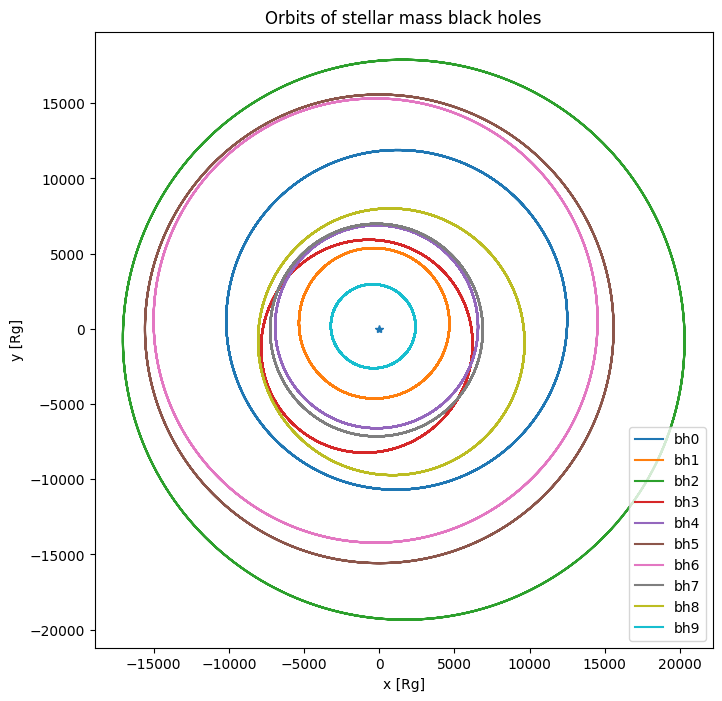

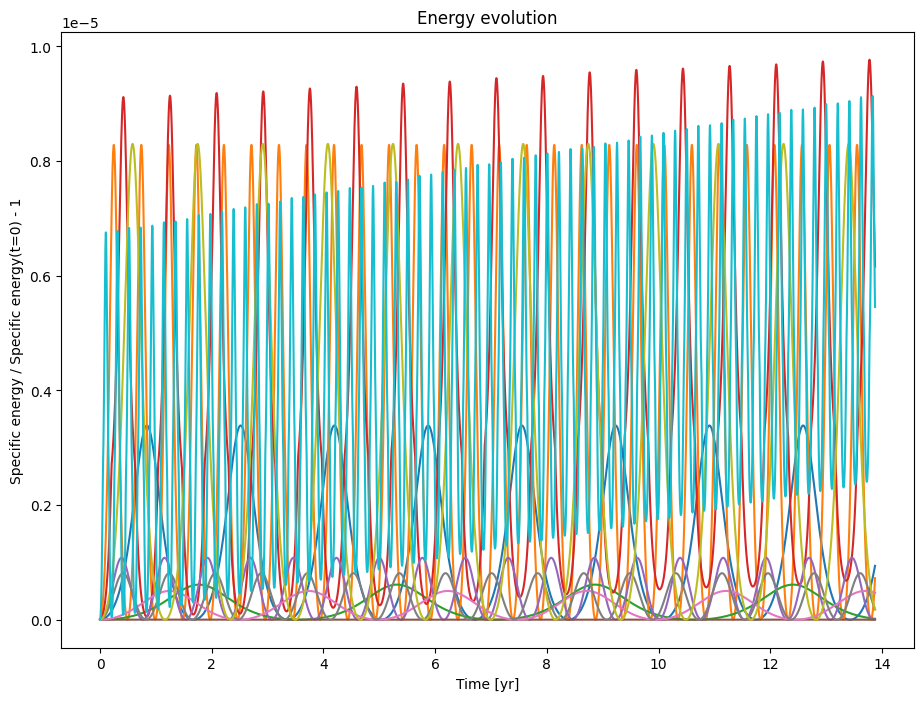

In [45]:
# calculate rotation period of each black hole for the last timestep
a = semi_major_axis(r,v)
P = period(r,v)
rr = np.sqrt(np.sum(pos**2,axis=0)).max(axis=1)
for i,a,rrr,p in zip(range(nbh),a,rr,P):
    print('P{:01}: a={:.0f} r={:.0f} Tend/P={:.1f}'.format(i,a,rrr,tend/p))

# make a simple plot of the orbits
plt.figure(figsize=(11,8))
plt.plot([0],[0],marker='*') # mark the SMBH

for i in range(nbh): # plot the orbits of the black holes
    plt.plot(pos[0,i],pos[1,i],label='bh{}'.format(i),color='C{}'.format(i))

plt.axis('scaled')
plt.xlabel('x [Rg]')
plt.ylabel('y [Rg]')
plt.title('Orbits of stellar mass black holes')
if nbh < 20:
    plt.legend()
plt.savefig('orbits_v1.png')

# Plot specific energy evolution for the particles
plt.figure(figsize=(11,8))
E = specific_energy(pos,vel)
for i in range(nbh):
    plt.plot(tim*u.t/u.yr,E[i] / E[i,0]-1,label='bh{}'.format(i),color='C{}'.format(i))
plt.xlabel('Time [yr]')
plt.ylabel('Specific energy / Specific energy(t=0) - 1')
plt.title('Energy evolution')
plt.savefig('energy_v1.png')

### Migration time-scales
The migration time-scales depends on the gravitational response of the accretion disk on the stellar mass black holes. It is similar to Bondi-Hoyle drag but in a rotating frame. The physics is very subtle because gas at smaller radius than the black hole rotates faster and will therefore speed it up (transfer a postive amount of angular momentum), while gas at larger radius the the black hole rotates slower and will therefore slow it down (transfer a negative amount of angular momentum). Furthermore, gas corotating with the black hole also excerts a so-called co-rotation torque. All these contributions are large but almost cancel, and the net torque is much much smaller. If it is positive or negative depends on the gradient in the surface density and the temperature profile, and related to this the opening angle (height divided by radius) of the disk. The amount of dust and the capacity of the stellar mass black hole to open a gap also impacts the final result.

Following Pichierri et al (2023) for 2D disks the net result is a change in the semi-major axis and a change in the eccentricity that can be expressed in terms of time-scales $\tau_\textrm{mig}$ and $\tau_\textrm{ecc}$ such that the total acceleration is written (see their equations (17) and (18))
\begin{equation}
\mathbf{a} = \mathbf{a}_\textrm{mig} + \mathbf{a}_\textrm{ecc}
\end{equation}
where
\begin{align}
\mathbf{a}_\textrm{mig} &= - \frac{1}{\tau_\textrm{mig}} \mathbf{v}_\textrm{bh} \\
\mathbf{a}_\textrm{ecc} &= - 2 \frac{1}{\tau_\textrm{ecc}} \frac{(\mathbf{v}_\textrm{bh} \cdot \mathbf{r}_\textrm{bh})}{|\mathbf{r}_\textrm{bh}|^2}\mathbf{r}_\textrm{bh}
\end{align}

To provide effective fitting formulas for the torque as a function of physical parameters it is neccessary to run large suites of hydrodynamical models and directly measure them. We will not do this, but instead I provide examples of such formulas, implemented in a python function. Because the time-sacle for migration is often in millions of orbits, I introduce a fudge factor, to speed up the migration (lower the time-scale) and make the problem tractable in a short exercise.

In [46]:
def torques(r,v,m,disk):
    ''' Torques of the disk on the stellar black holes '''
    rr = np.sqrt(np.sum(r**2,axis=0))
    Sigma, T, HR, alpha, beta = disk(rr)
    omega = np.sqrt(GM / rr**3)
    e = eccentricity(r,v)
    ehat = e / HR

    # Fudge factor to reduce migration times
    # to something closer to orbital time-scale
    fudge_factor = 1e-4

    tau_wave = HR**4 / (Sigma*rr**2*omega*m) # wave torque for Type I migration assuming units where M_SMBH=1
    Pe = (1 + (ehat/2.25)**2 + (ehat/2.84)**6)/(1 - (ehat/2.02)**4) # eccentricity damping

    tau_mig = fudge_factor * tau_wave / (-1.88 - 0.86 * alpha + 0.3 * beta) / HR**2 * Pe # migration torque for Type I migration
    tau_ecc = tau_wave / 0.78 #* (1 - 0.14 * ehat**2 + 0.06 * ehat**3) # eccentricity damping torque

    return tau_mig, tau_ecc

Unit of length (R_g)  [AU]   : 0.0197
Unit of time (R_g/c)  [yr]   : 3.12e-07
Unit of mass (M_smbh) [Msun] : 1e+06
Outward migration trap start at r= 1734.1905183798888 4234
Outward migration trap end at r= 1739.4076794908658 4236
Outward migration trap start at r= 1742.0221428640727 4237
Outward migration trap end at r= 1747.2628647351096 4239
Outward migration trap start at r= 1749.889135055214 4240
Outward migration trap end at r= 1752.519352861374 4241
Outward migration trap start at r= 5487.842101416549 5001
Outward migration trap end at r= 5504.351796338339 5003
Outward migration trap start at r= 5512.625259963017 5004
Outward migration trap end at r= 5529.209512858459 5006
Outward migration trap start at r= 5537.520339540773 5007
Outward migration trap end at r= 5545.843658034087 5008
Outward migration trap start at r= 13473.168961818212 5599
Outward migration trap end at r= 13513.701817005825 5601
Outward migration trap start at r= 13946.729484150797 5622
Outward migration trap

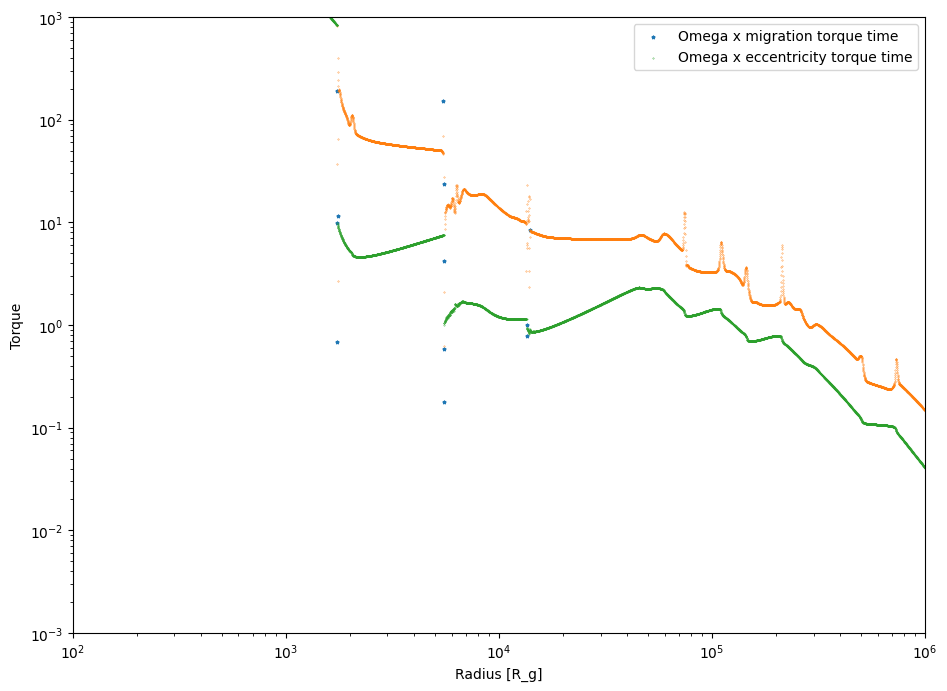

In [47]:
AGN = AGN_disk(disk_model='/Users/ChamillaTerp/Dropbox/Skole/Master/Computational Astrophysics/7-Particles/Thompson_SMBH_1e6.npz')

# Test routine by setting up a radius array with Keplerian speed
vk = np.sqrt(GM / AGN.R) 
vv = np.zeros((3,len(vk)))
vv[1] = vk
rr = np.zeros((3,len(vk)))
rr[0] = AGN.R

m = 1e-5 # assume mass of stellar black hole ot be 1e6 x 1e-5 = 10 Msun

tau_mig, tau_ecc = torques(rr,vv,m,AGN.disk)
omega = np.sqrt(GM / AGN.R**3)

plt.figure(figsize=(11,8))
plt.scatter(AGN.R[tau_mig > 0],(tau_mig*omega)[tau_mig > 0],marker='*',s=5, label='Omega x migration torque time')
plt.scatter(AGN.R[tau_mig < 0],(np.abs(tau_mig)*omega)[tau_mig < 0],marker='.',s=0.3)
plt.scatter(AGN.R[tau_ecc > 0],(tau_ecc*omega)[tau_ecc > 0],marker='.',s=0.3,label='Omega x eccentricity torque time')
plt.scatter(AGN.R[tau_ecc < 0],(np.abs(tau_ecc)*omega)[tau_ecc < 0],marker='.',s=0.3)
plt.xlabel('Radius [R_g]')
plt.ylabel('Torque')
plt.legend()
plt.xscale('log')
plt.xlim(1e2,1e6)
plt.ylim(1e-3,1e3)
plt.yscale('log')

# detect migration traps as places where, with increasing radius,
# there is a sign change from positive (outwards) to negative (inwards) migration
R_trap = []
for ii in range(len(tau_mig)-1):
    if (tau_mig[ii+1] < 0) and (tau_mig[ii] > 0):
        R_trap.append(AGN.R[ii])
        print('Outward migration trap end at r=',AGN.R[ii],ii)
    if (tau_mig[ii+1] > 0) and (tau_mig[ii] < 0):
        print('Outward migration trap start at r=',AGN.R[ii],ii)
R_trap = np.array(R_trap)

## Tasks

### Task 1 (30p): Add gravitational acceleration from the stellar mass black holes to the model
Currently the ```a_gravity``` only calculates the gravitation acceleration from the central black hole. While it dominates the problem, there can also be close encounters betweem the stellar mass black holes in the disk. Write a new ```a_gravity``` function (call it something else) that includes the gravitational acceleration from all particles. To test it, rerun the example from above. How has it changed; comment on the orbital and energy plots. [Hint: when implementing the routine rememeber to only calculate the acceleration for the particles that are active in the timegroup as indicated by the ```mask``` argument to the routine.]

### Task 2 (30p): Add migration acceleration from the accretion disk to the model
Use the equations from Pichierri et al (2023) to calculate the acceleration from disk torques and implement it in a function that you can use instead of ```a_headwind```. Test it again on the standard model. Add a plot of how the radius changes as a function of time for the stellar mass black holes. How has the results now changed. Does it make sense? [Hint: it may be useful to overplot the radial position of migration traps]

### Task 3 (40p): Add a merger module to the model
Increse the number of black holes to e.g. 50. Then integration becomes slower, and after some time grinds to a halt. This is because binary pairs of stellar black holes are formed in the disk, and they evovle with a much shorter orbital period (and therefore timestep) than single black holes. Physically, such pairs are strong candidates for gravitational merger events. To make the model run again, and include the merging of particles, create a routine that detects mergers (defined as pairs of particles that are more bound to each other than to the central black hole). When a merger is detected, one of the particles should become the merged particle, while the other particle is initialised again somewhere in the disk, to keep the merger machine going! Explain and argue for how you have built the merger routine.

# __Absalon turn-in:__

Please add the updated code below this line together with plots and your supporting discussion of the results. Upload the notebook and a pdf copy of the notebook.
As the turn-in, copy over important figures and your discussion to a PDF document together with the code for the three routines that you implemented. This will make it much easier to correct.

#### __Task 1__: Add gravitational acceleration from the stellar mass black holes to the model


In [48]:
@nb.njit
def a_gravity_new(r,m,mask):
    ''' Acceleration of particles due to gravity
        r,v,m: position, velocity and mass of particles
        mask: mask to select particles to be updated
    '''
    GM = 2
    acc = -GM * r[:,mask] / np.sum(r[:,mask]**2,axis=0)**1.5  # contribution from SMBH
    # print("SMBH acc shape:", np.shape(acc))
    # print("mask:", mask)

    # print("main acc:",acc)

    idx = np.where(mask)[0]  # get the indices of the particles in the mask
    # print("idx:", idx)

    #Expand to include the acceleration from all particles
    for i, particle_number in enumerate(idx):
        for j in range(r.shape[1]):
            if particle_number != j:                 # exclude self-gravity
                
                dr = r[:,particle_number] - r[:,j]  
                acc[:,i] += -GM * m[j] * dr / np.sum(dr**2)**1.5                                   
                
    # acc will have the same shape as r[:,mask], e.g. (3,nmask), where nmask is the number of particles in the mask

    return acc

In [49]:
nbh=10   # number of stellar mass black holes
mbh=10   # mass of stellar mass black holes [Msun]
Cdt=0.01 # Courant number for integration

print('Setting up stellar mass black holes around a supermassive black hole')
print('Number of particles:',nbh)
print('Mass of stellar mass black holes [Msun]:',mbh)

AGN = AGN_disk()

# Pick up units and mass of central black hole from disk model
SMBH = AGN.SMBH
u = AGN.units

rad=1e4  # typical radius of the stellar mass black holes [Rg]
rmin=1e3 # minimum starting radius [Rg]
rmax=1e5 # maximum starting radius [Rg]
dispersion=0.5 # logarithmic dispersion around the radius
edispersion=0.1 # dispersion in eccentricity
emax=0.2        # maximum eccentricity
seed=1234       # seed for random number generator

r,v,m = setup_particles(nbh=nbh, SMBH=SMBH, mbh=mbh, rad=rad, rmin=rmin, rmax=rmax, \
                        dispersion=dispersion, edispersion=edispersion, emax=emax, seed=seed)

# Setup the integrator
integrator = Integrator(GM=GM, Cdt=Cdt, units=u, migration=a_headwind, merger=test_for_merger, a_gravity=a_gravity_new)

dt_step = 1e-3 * 2*np.pi*np.sqrt(rad**3/2) # Output frequency in numerical units (1000 points per orbit)
tend = 10. * 2*np.pi*np.sqrt(rad**3/2)     # End time in numerical units (10 orbits)

print('Frequency of output points: {:.2g} yr'.format(dt_step * u.t / u.yr))
print('End time: {:.2g} yr'.format(tend * u.t / u.yr))

tim = []; tim.append(0)                    # store time
pos = []; pos.append(np.copy(r))           # store position
vel = []; vel.append(np.copy(v))           # store velocity

now = time(); begin=now # measure wall clock time for progress print-out
t = 0                   # start time [code units]
while t < tend:
    dtime = min(dt_step,tend-t) # time step to integrate
    integrator.integrate_model(r,v,m,dtime) # integrate model to tnext
    t += dtime                  # update time

    tim.append(t)          # store time
    pos.append(np.copy(r)) # store position
    vel.append(np.copy(v)) # store velocity

    if time() - now > 10: # diagnostic print-out every 10 seconds
        print('t={:.2f} tend'.format(t / tend), end='\r')
        now += 10

print('Integration finished succesfully in {:.2f} seconds'.format(time()-begin))

# convert lists to numpy arrays and transpose the position and velocity arrays such that coordinates are in the first index
tim = np.array(tim)   # [#its]
pos = np.array(pos).transpose([1,2,0])   # [3,nbh,#its]
vel = np.array(vel).transpose([1,2,0])   # [3,nbh,#its]

Setting up stellar mass black holes around a supermassive black hole
Number of particles: 10
Mass of stellar mass black holes [Msun]: 10
Unit of length (R_g)  [AU]   : 0.0197
Unit of time (R_g/c)  [yr]   : 3.12e-07
Unit of mass (M_smbh) [Msun] : 1e+06
Frequency of output points: 0.0014 yr
End time: 14 yr
Integration finished succesfully in 5.65 seconds


P0: a=11352 r=12689 Tend/P=8.3
P1: a=5003 r=5523 Tend/P=28.3
P2: a=18702 r=20567 Tend/P=3.9
P3: a=7023 r=8553 Tend/P=17.0
P4: a=7128 r=7451 Tend/P=16.6
P5: a=15568 r=15608 Tend/P=5.1
P6: a=14789 r=15386 Tend/P=5.6
P7: a=6819 r=7404 Tend/P=17.8
P8: a=8916 r=10104 Tend/P=11.9
P9: a=2822 r=3259 Tend/P=66.7


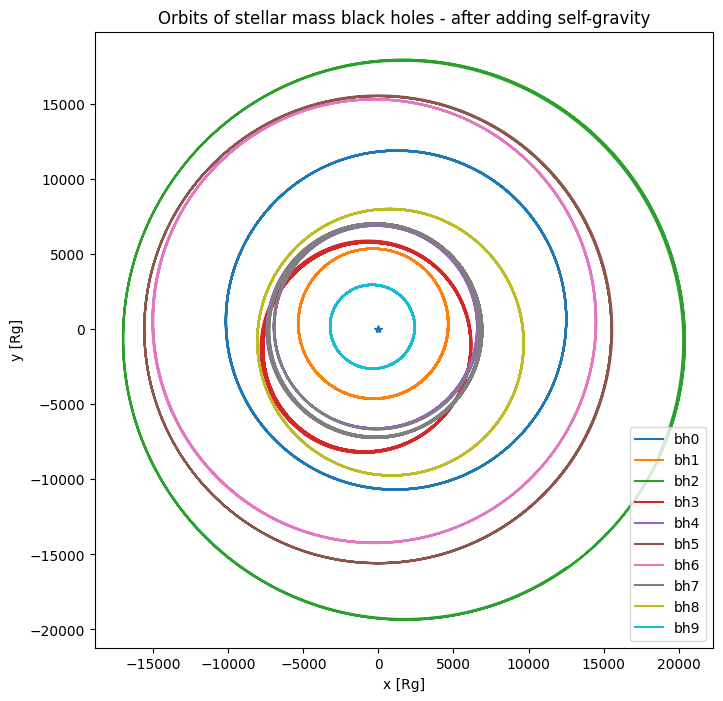

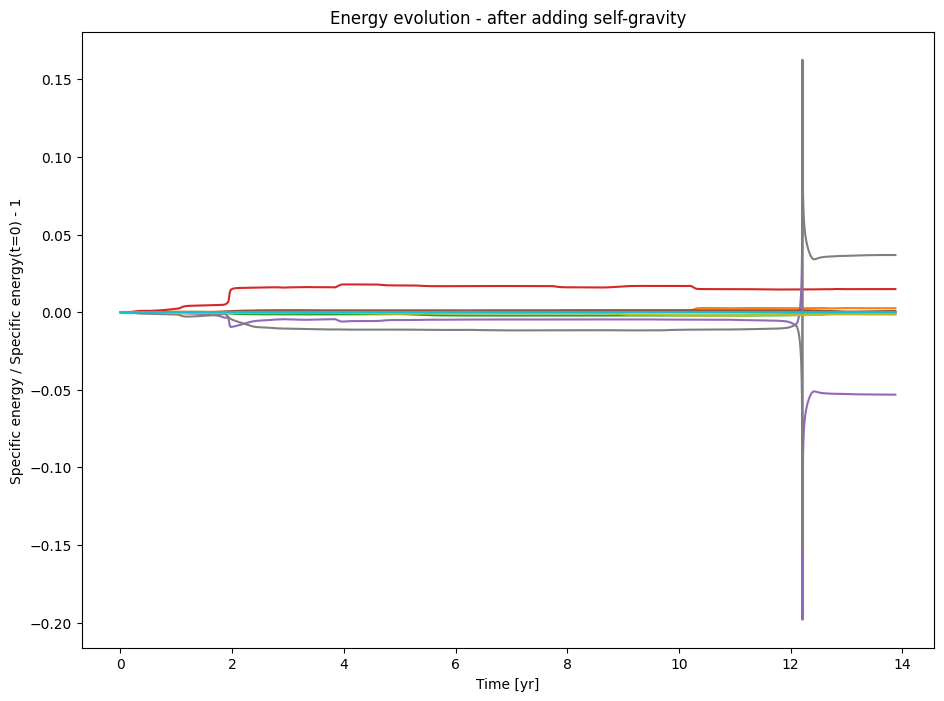

In [50]:
# calculate rotation period of each black hole for the last timestep
a = semi_major_axis(r,v)
P = period(r,v)
rr = np.sqrt(np.sum(pos**2,axis=0)).max(axis=1)
for i,a,rrr,p in zip(range(nbh),a,rr,P):
    print('P{:01}: a={:.0f} r={:.0f} Tend/P={:.1f}'.format(i,a,rrr,tend/p))

# make a simple plot of the orbits
plt.figure(figsize = (11, 8))
plt.plot([0], [0], marker = '*') # mark the SMBH

for i in range(nbh): # plot the orbits of the black holes
    plt.plot(pos[0,i],pos[1,i],label='bh{}'.format(i),color='C{}'.format(i))

plt.axis('scaled')
plt.xlabel('x [Rg]')
plt.ylabel('y [Rg]')
plt.title('Orbits of stellar mass black holes - after adding self-gravity')
if nbh < 20:
    plt.legend()
plt.savefig('orbits_v2.png')

# Plot specific energy evolution for the particles
plt.figure(figsize=(11,8))
E = specific_energy(pos,vel)
for i in range(nbh):
    plt.plot(tim*u.t/u.yr, E[i] / E[i,0]-1,label='bh{}'.format(i),color='C{}'.format(i))
plt.xlabel('Time [yr]')
plt.ylabel('Specific energy / Specific energy(t=0) - 1')
plt.title('Energy evolution - after adding self-gravity')
plt.savefig('energy_v2.png')

#### __Task 2__: Add migration acceleration from the accretion disk to the model

In [51]:
def a_headwind_new(r, v, m, mask):
    ''' Default empty implementation of migration torques '''

    # Making the masks 
    r = r[:,mask]
    v = v[:,mask]
    m = m[mask]

    # Getting the timescales using the "torques" function
    tau_mig, tau_ecc = torques(r, v, m, AGN.disk)

    # Using the Pichierri et al (2023) equations
    a_mig = -v/tau_mig[None, :]
    a_ecc = -2/tau_ecc[None, :] * (np.sum(v * r, axis = 0)) * r/(np.sum(r**2, axis = 0)) 

    a = a_mig + a_ecc

    return a

In [79]:
nbh=10   # number of stellar mass black holes
mbh=10   # mass of stellar mass black holes [Msun]
Cdt=0.01 # Courant number for integration

print('Setting up stellar mass black holes around a supermassive black hole')
print('Number of particles:',nbh)
print('Mass of stellar mass black holes [Msun]:',mbh)

AGN = AGN_disk()

# Pick up units and mass of central black hole from disk model
SMBH = AGN.SMBH
u = AGN.units

rad = 1e4  # typical radius of the stellar mass black holes [Rg]
rmin = 1e3 # minimum starting radius [Rg]
rmax = 1e5 # maximum starting radius [Rg]
dispersion = 0.5 # logarithmic dispersion around the radius
edispersion = 0.1 # dispersion in eccentricity
emax = 0.2        # maximum eccentricity
seed = 1234       # seed for random number generator

r,v,m = setup_particles(nbh=nbh, SMBH=SMBH, mbh=mbh, rad=rad, rmin=rmin, rmax=rmax, \
                        dispersion=dispersion, edispersion=edispersion, emax=emax, seed=seed)

# Setup the integrator
integrator = Integrator(GM=GM, Cdt=Cdt, units=u, migration=a_headwind_new, merger=test_for_merger, a_gravity=a_gravity_new)

dt_step = 1e-3 * 2*np.pi*np.sqrt(rad**3/2) # Output frequency in numerical units (1000 points per orbit)
tend = 10. * 2*np.pi*np.sqrt(rad**3/2)     # End time in numerical units (10 orbits)

print('Frequency of output points: {:.2g} yr'.format(dt_step * u.t / u.yr))
print('End time: {:.2g} yr'.format(tend * u.t / u.yr))

tim = []; tim.append(0)                    # store time
pos = []; pos.append(np.copy(r))           # store position
vel = []; vel.append(np.copy(v))           # store velocity

now = time(); begin=now # measure wall clock time for progress print-out
t = 0                   # start time [code units]
while t < tend:
    dtime = min(dt_step,tend-t) # time step to integrate
    integrator.integrate_model(r,v,m,dtime) # integrate model to tnext
    t += dtime                  # update time

    tim.append(t)          # store time
    pos.append(np.copy(r)) # store position
    vel.append(np.copy(v)) # store velocity

    if time() - now > 10: # diagnostic print-out every 10 seconds
        print('t={:.2f} tend'.format(t / tend), end='\r')
        now += 10

print('Integration finished succesfully in {:.2f} seconds'.format(time()-begin))

# convert lists to numpy arrays and transpose the position and velocity arrays such that coordinates are in the first index
tim = np.array(tim)   # [#its]
pos = np.array(pos).transpose([1,2,0])   # [3,nbh,#its]
vel = np.array(vel).transpose([1,2,0])   # [3,nbh,#its]

Setting up stellar mass black holes around a supermassive black hole
Number of particles: 10
Mass of stellar mass black holes [Msun]: 10
Unit of length (R_g)  [AU]   : 0.0197
Unit of time (R_g/c)  [yr]   : 3.12e-07
Unit of mass (M_smbh) [Msun] : 1e+06
Frequency of output points: 0.0014 yr
End time: 14 yr
Integration finished succesfully in 37.79 seconds


P0: a=6088 r=12658 Tend/P=21.1
P1: a=1833 r=5513 Tend/P=127.4
P2: a=14323 r=20470 Tend/P=5.8
P3: a=5766 r=8553 Tend/P=22.8
P4: a=5602 r=6975 Tend/P=23.8
P5: a=15977 r=15923 Tend/P=5.0
P6: a=6628 r=15369 Tend/P=18.5
P7: a=5698 r=7274 Tend/P=23.2
P8: a=5978 r=10079 Tend/P=21.6
P9: a=1833 r=3258 Tend/P=127.4


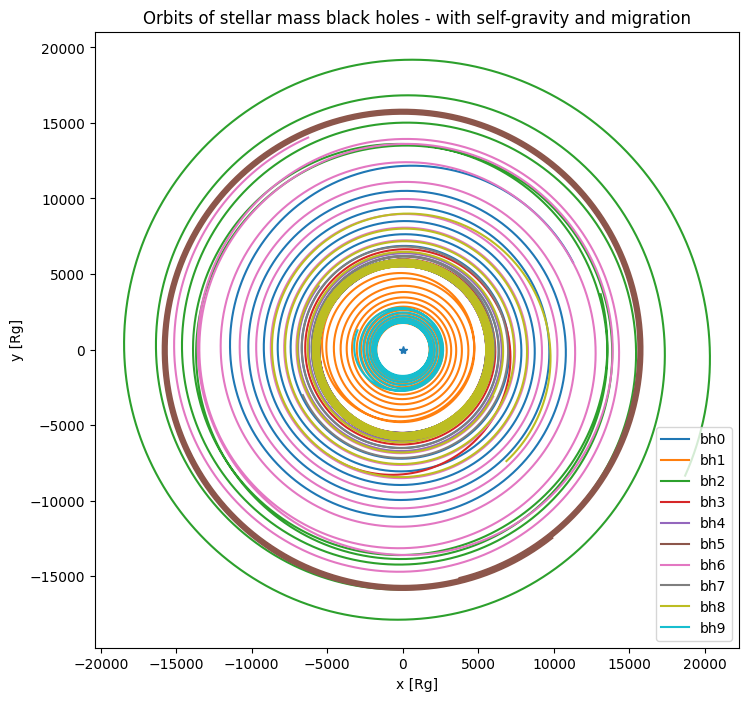

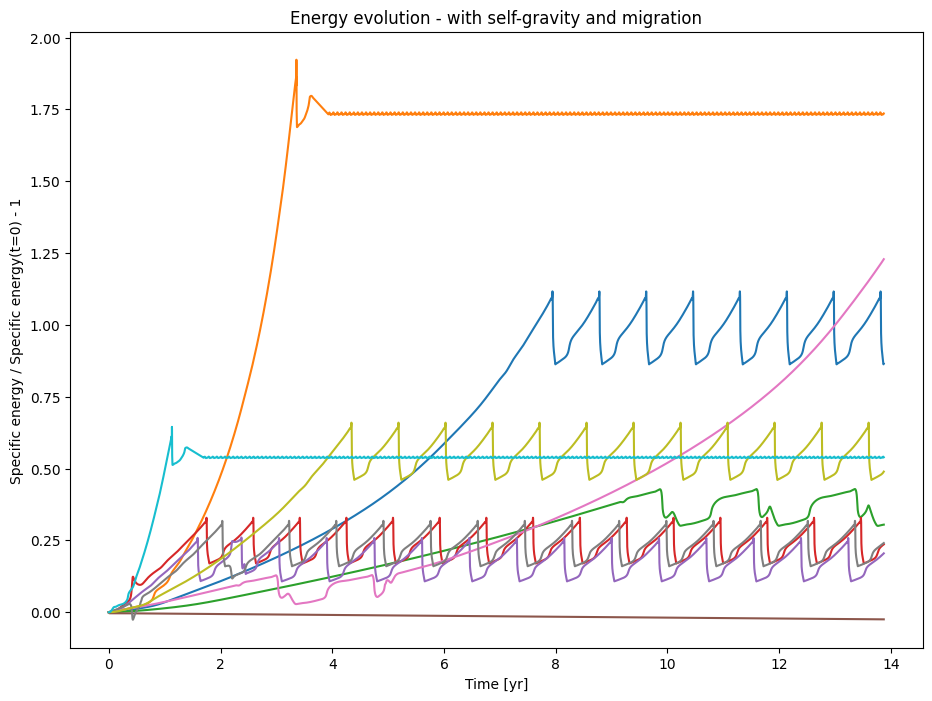

In [80]:
a = semi_major_axis(r,v)
P = period(r,v)
rr = np.sqrt(np.sum(pos**2,axis=0)).max(axis=1)
for i,a,rrr,p in zip(range(nbh),a,rr,P):
    print('P{:01}: a={:.0f} r={:.0f} Tend/P={:.1f}'.format(i,a,rrr,tend/p))

# make a simple plot of the orbits
plt.figure(figsize=(11,8))
plt.plot([0],[0], marker='*') # mark the SMBH

for i in range(nbh): # plot the orbits of the black holes
    plt.plot(pos[0,i],pos[1,i],label='bh{}'.format(i),color='C{}'.format(i))

plt.axis('scaled')
plt.xlabel('x [Rg]')
plt.ylabel('y [Rg]')
plt.title('Orbits of stellar mass black holes - with self-gravity and migration')
if nbh < 20:
    plt.legend()
plt.savefig('orbits_v3.png')

# Plot specific energy evolution for the particles
plt.figure(figsize = (11, 8))
E = specific_energy(pos, vel)
for i in range(nbh):
    plt.plot(tim*u.t/u.yr, E[i] / E[i,0]-1, label='bh{}'.format(i), color='C{}'.format(i))
plt.xlabel('Time [yr]')
plt.ylabel('Specific energy / Specific energy(t=0) - 1')
plt.title('Energy evolution - with self-gravity and migration')
plt.savefig('energy_v3.png')

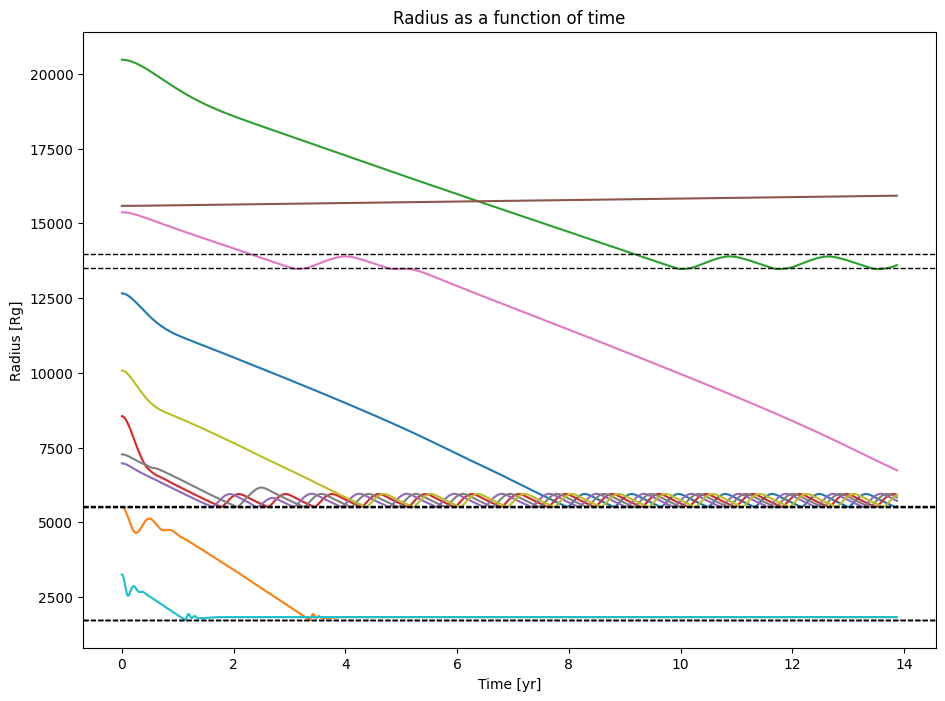

In [81]:
# Plotting the radius as a function of time
plt.figure(figsize = (11, 8))
for i in range(nbh):
    plt.plot(tim*u.t/u.yr, np.sqrt(np.sum(pos[:,i]**2, axis = 0)), label = 'bh{}'.format(i), color = 'C{}'.format(i))

# Plotting R_trap over 
for i in R_trap:
    plt.axhline(i, color = 'black', linestyle = '--', linewidth = '1')

plt.xlabel('Time [yr]')
plt.ylabel('Radius [Rg]')
plt.title('Radius as a function of time')
plt.savefig('radius_v3.png')

#### __Task 3__: Add a merger module to the model
Increse the number of black holes to e.g. 50. Then integration becomes slower, and after some time grinds to a halt. This is because binary pairs of stellar black holes are formed in the disk, and they evovle with a much shorter orbital period (and therefore timestep) than single black holes. Physically, such pairs are strong candidates for gravitational merger events. To make the model run again, and include the merging of particles, create a routine that detects mergers (defined as pairs of particles that are more bound to each other than to the central black hole). When a merger is detected, one of the particles should become the merged particle, while the other particle is initialised again somewhere in the disk, to keep the merger machine going! Explain and argue for how you have built the merger routine.

In [55]:
# Running the integration with 50 black holes
nbh = 50   # number of stellar mass black holes
mbh = 10   # mass of stellar mass black holes [Msun]
Cdt = 0.01 # Courant number for integration

print('Setting up stellar mass black holes around a supermassive black hole')
print('Number of particles:',nbh)
print('Mass of stellar mass black holes [Msun]:',mbh)

AGN = AGN_disk()

# Pick up units and mass of central black hole from disk model
SMBH = AGN.SMBH
u = AGN.units

rad=1e4  # typical radius of the stellar mass black holes [Rg]
rmin=1e3 # minimum starting radius [Rg]
rmax=1e5 # maximum starting radius [Rg]
dispersion=0.5 # logarithmic dispersion around the radius
edispersion=0.1 # dispersion in eccentricity
emax=0.2        # maximum eccentricity
seed=1234       # seed for random number generator

r,v,m = setup_particles(nbh=nbh, SMBH=SMBH, mbh=mbh, rad=rad, rmin=rmin, rmax=rmax, \
                        dispersion=dispersion, edispersion=edispersion, emax=emax, seed=seed)

# Setup the integrator
integrator = Integrator(GM=GM, Cdt=Cdt, units=u, migration=a_headwind_new, merger=test_for_merger, a_gravity=a_gravity_new)

dt_step = 1e-3 * 2*np.pi*np.sqrt(rad**3/2) # Output frequency in numerical units (1000 points per orbit)
tend = 10. * 2*np.pi*np.sqrt(rad**3/2)     # End time in numerical units (10 orbits)

print('Frequency of output points: {:.2g} yr'.format(dt_step * u.t / u.yr))
print('End time: {:.2g} yr'.format(tend * u.t / u.yr))

tim = []; tim.append(0)                    # store time
pos = []; pos.append(np.copy(r))           # store position
vel = []; vel.append(np.copy(v))           # store velocity

now = time(); begin=now # measure wall clock time for progress print-out
t = 0                   # start time [code units]
while t < tend and (now - begin) < 60:
    dtime = min(dt_step,tend-t) # time step to integrate
    integrator.integrate_model(r,v,m,dtime) # integrate model to tnext
    t += dtime                  # update time

    tim.append(t)          # store time
    pos.append(np.copy(r)) # store position
    vel.append(np.copy(v)) # store velocity

    if time() - now > 10: # diagnostic print-out every 10 seconds
        print('t={:.2f} tend'.format(t / tend), end='\r')
        now += 10

print('Integration finished succesfully in {:.2f} seconds'.format(time()-begin))

# convert lists to numpy arrays and transpose the position and velocity arrays such that coordinates are in the first index
tim = np.array(tim)   # [#its]
pos = np.array(pos).transpose([1,2,0])   # [3,nbh,#its]
vel = np.array(vel).transpose([1,2,0])   # [3,nbh,#its]

Setting up stellar mass black holes around a supermassive black hole
Number of particles: 50
Mass of stellar mass black holes [Msun]: 10
Unit of length (R_g)  [AU]   : 0.0197
Unit of time (R_g/c)  [yr]   : 3.12e-07
Unit of mass (M_smbh) [Msun] : 1e+06
Frequency of output points: 0.0014 yr
End time: 14 yr
Integration finished succesfully in 60.28 seconds


P0: a=8207 r=12658 Tend/P=13.5
P1: a=1836 r=5513 Tend/P=127.1
P2: a=15245 r=20470 Tend/P=5.3
P3: a=5363 r=8553 Tend/P=25.5
P4: a=5708 r=6975 Tend/P=23.2
P5: a=13120 r=15583 Tend/P=6.7
P6: a=12629 r=15369 Tend/P=7.0
P7: a=5601 r=7274 Tend/P=23.9
P8: a=5432 r=10079 Tend/P=25.0
P9: a=1836 r=3258 Tend/P=127.1
P10: a=13514 r=17772 Tend/P=6.4
P11: a=12838 r=16421 Tend/P=6.9
P12: a=13352 r=16107 Tend/P=6.5
P13: a=1831 r=3640 Tend/P=127.7
P14: a=6040 r=8462 Tend/P=21.3
P15: a=13311 r=14885 Tend/P=6.5
P16: a=6150 r=12247 Tend/P=20.7
P17: a=6026 r=11555 Tend/P=21.4
P18: a=15527 r=19359 Tend/P=5.2
P19: a=1836 r=4614 Tend/P=127.1
P20: a=1459 r=9036 Tend/P=179.4
P21: a=6004 r=7204 Tend/P=21.5
P22: a=8558 r=11015 Tend/P=12.6
P23: a=9123 r=13188 Tend/P=11.5
P24: a=14947 r=19330 Tend/P=5.5
P25: a=5696 r=7908 Tend/P=23.3
P26: a=10455 r=14018 Tend/P=9.4
P27: a=3853 r=4031 Tend/P=41.8
P28: a=4378 r=9125 Tend/P=34.5
P29: a=13396 r=16981 Tend/P=6.4
P30: a=5572 r=8196 Tend/P=24.0
P31: a=5774 r=11838 Tend/P=

Text(0.5, 1.0, 'Energy evolution')

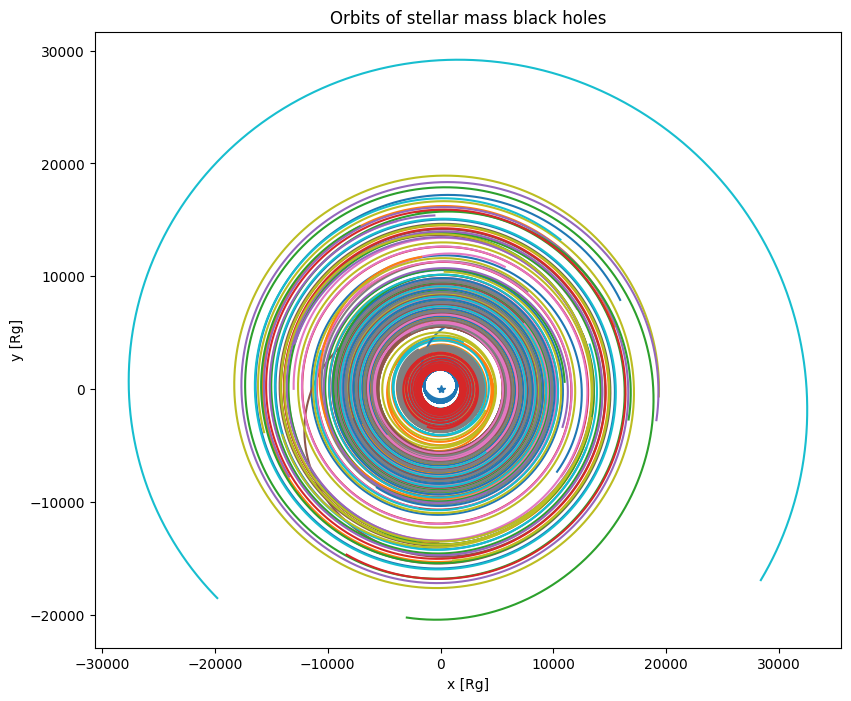

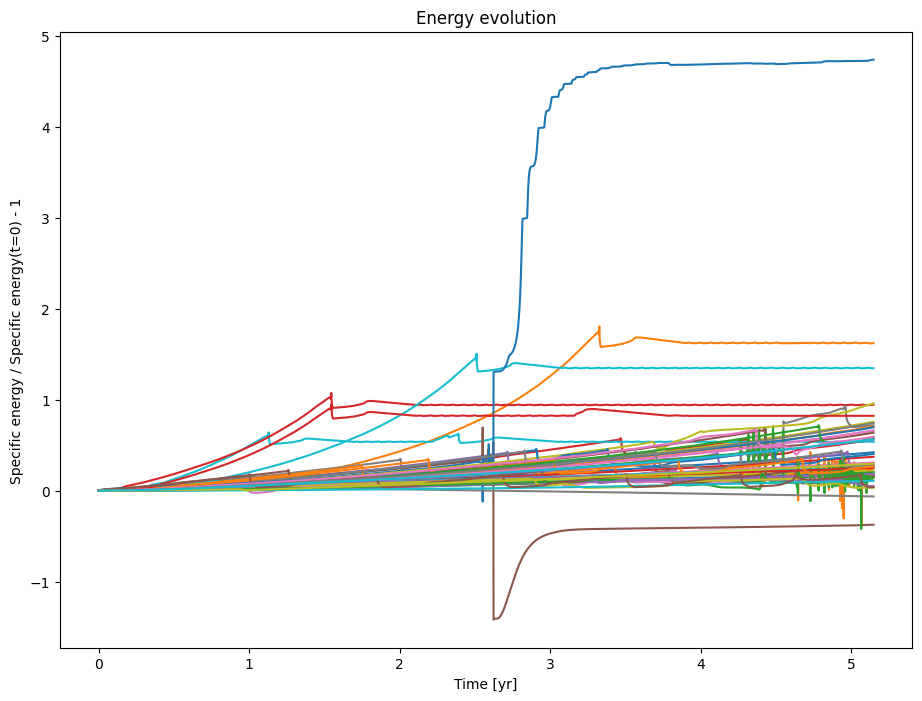

In [56]:
a = semi_major_axis(r,v)
P = period(r,v)
rr = np.sqrt(np.sum(pos**2,axis=0)).max(axis=1)
for i,a,rrr,p in zip(range(nbh),a,rr,P):
    print('P{:01}: a={:.0f} r={:.0f} Tend/P={:.1f}'.format(i,a,rrr,tend/p))

# make a simple plot of the orbits
plt.figure(figsize=(11,8))
plt.plot([0],[0], marker='*') # mark the SMBH

for i in range(nbh): # plot the orbits of the black holes
    plt.plot(pos[0,i],pos[1,i],label='bh{}'.format(i),color='C{}'.format(i))

plt.axis('scaled')
plt.xlabel('x [Rg]')
plt.ylabel('y [Rg]')
plt.title('Orbits of stellar mass black holes')
if nbh < 20:
    plt.legend();

# Plot specific energy evolution for the particles
plt.figure(figsize = (11, 8))
E = specific_energy(pos, vel)
for i in range(nbh):
    plt.plot(tim*u.t/u.yr, E[i] / E[i,0]-1, label='bh{}'.format(i), color='C{}'.format(i))
plt.xlabel('Time [yr]')
plt.ylabel('Specific energy / Specific energy(t=0) - 1')
plt.title('Energy evolution')

Text(0.5, 1.0, 'Radius as a function of time')

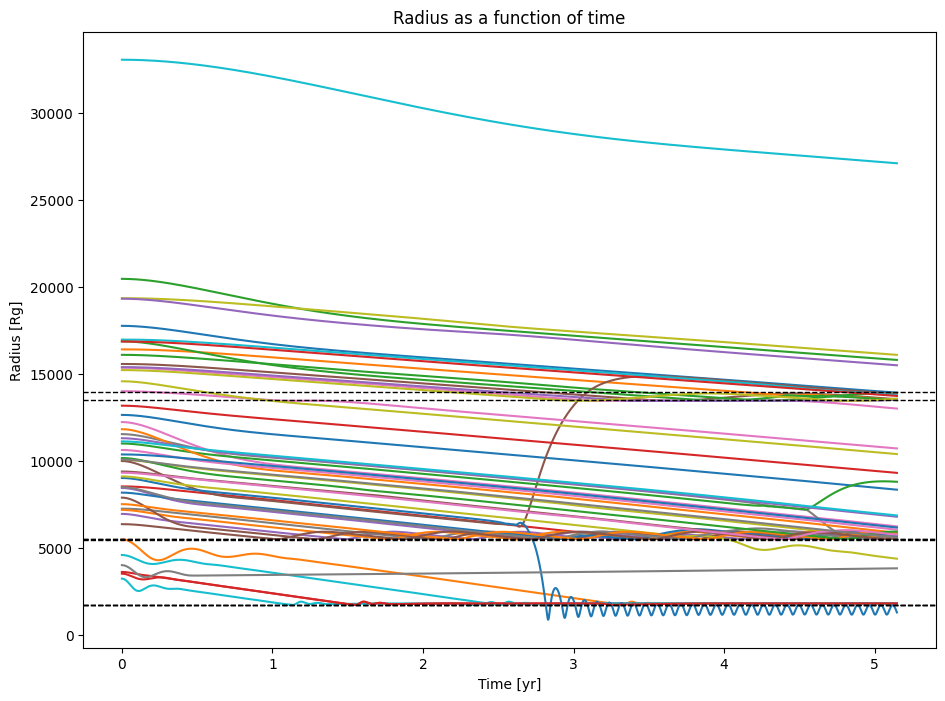

In [57]:
# Plotting the radius as a function of time
plt.figure(figsize = (11, 8))
for i in range(nbh):
    plt.plot(tim*u.t/u.yr, np.sqrt(np.sum(pos[:,i]**2, axis = 0)), label = 'bh{}'.format(i), color = 'C{}'.format(i))

# Plotting R_trap over 
for i in R_trap:
    plt.axhline(i, color = 'black', linestyle = '--', linewidth = '1')

plt.xlabel('Time [yr]')
plt.ylabel('Radius [Rg]')
plt.title('Radius as a function of time')

In [117]:
def test_for_merger_new(r, v, m, mask):
    """ Implement a test for mergers """

    # check for mergers when gravity from other particles is larger than gravity from SMBH
    E_smbh = specific_energy(r, v)  # specific energy of particles
    idx = np.where(mask)[0]

    for i, particle_number in enumerate(idx):
        for j in range(r.shape[1]):
            if particle_number != j:
                # Relative position and velocity
                dr = np.abs(r[:, j] - r[:, particle_number])  # Relative position/distance

                # Center of mass frame (removing contribution from the SMBH)
                total_mass = m[particle_number] + m[j]
                r_cm = (m[particle_number] * r[:, particle_number] + m[j] * r[:, j]) / total_mass
                v_cm = (m[particle_number] * v[:, particle_number] + m[j] * v[:, j]) / total_mass

                U_pair = -GM * m[particle_number] * m[j] / np.sum(dr**2)
                K_pair = (0.5 * m[particle_number] * np.sum((v[:, particle_number] - v_cm)**2) +
                          0.5 * m[j] * np.sum((v[:, j] - v_cm)**2))

                E_pair = U_pair + K_pair

                energy_threshold = 1e-6  # Adjust this threshold as needed
                if E_pair < E_smbh[particle_number] - energy_threshold:
                    # Update the surviving black hole
                    m[particle_number] = total_mass
                    r[:, particle_number] = r_cm
                    v[:, particle_number] = v_cm

                    # Reinitialize the merged black hole (particle j) using setup_particles
                    r_new, v_new, m_new = setup_particles(nbh=1, SMBH=SMBH, mbh=mbh, rad=rad, rmin=rmin, rmax=rmax, 
                                                          dispersion=dispersion, edispersion=edispersion, emax=emax, seed=seed)

                    # Giving the new particle a random generated position, velocity, and mass of the merged particles
                    r[:, j] = r_new[:, j]
                    v[:, j] = v_new[:, j]
                    m[j] = m_new[j]
                    print('Particle {} is re-initialized'.format(j))

                    return particle_number, j

    return -1, -1


In [126]:
# Running the integration with 50 black holes
nbh = 50   # number of stellar mass black holes
mbh = 10   # mass of stellar mass black holes [Msun]
Cdt = 0.01 # Courant number for integration

print('Setting up stellar mass black holes around a supermassive black hole')
print('Number of particles:', nbh)
print('Mass of stellar mass black holes [Msun]:', mbh)

AGN = AGN_disk()

# Pick up units and mass of central black hole from disk model
SMBH = AGN.SMBH
u = AGN.units

rad=1e4                             # typical radius of the stellar mass black holes [Rg]
rmin=1e3                            # minimum starting radius [Rg]
rmax=1e5                            # maximum starting radius [Rg]
dispersion=0.5                      # logarithmic dispersion around the radius
edispersion=0.1                     # dispersion in eccentricity
emax=0.2                            # maximum eccentricity
seed=1234                           # seed for random number generator

r,v,m = setup_particles(nbh=nbh, SMBH=SMBH, mbh=mbh, rad=rad, rmin=rmin, rmax=rmax, \
                        dispersion=dispersion, edispersion=edispersion, emax=emax, seed=seed)

# Setup the integrator
integrator = Integrator(GM=GM, Cdt=Cdt, units=u, migration=a_headwind_new, merger=test_for_merger_new, a_gravity=a_gravity_new)

dt_step = 1e-3 * 2*np.pi*np.sqrt(rad**3/2) # Output frequency in numerical units (1000 points per orbit)
tend = 10. * 2*np.pi*np.sqrt(rad**3/2)     # End time in numerical units (10 orbits)

print('Frequency of output points: {:.2g} yr'.format(dt_step * u.t / u.yr))
print('End time: {:.2g} yr'.format(tend * u.t / u.yr))

tim = []; tim.append(0)                    # store time
pos = []; pos.append(np.copy(r))           # store position
vel = []; vel.append(np.copy(v))           # store velocity

now = time(); begin=now # measure wall clock time for progress print-out
t = 0                   # start time [code units]
while t < tend and (now - begin) < 3000:
    dtime = min(dt_step,tend-t) # time step to integrate
    integrator.integrate_model(r, v, m, dtime) # integrate model to tnext
    t += dtime                  # update time

    tim.append(t)          # store time
    pos.append(np.copy(r)) # store position
    vel.append(np.copy(v)) # store velocity

    if time() - now > 10: # diagnostic print-out every 10 seconds
        print('t={:.2f} tend'.format(t / tend), end='\r')
        now += 10

print('Integration finished succesfully in {:.2f} seconds'.format(time()-begin))

# convert lists to numpy arrays and transpose the position and velocity arrays such that coordinates are in the first index
tim = np.array(tim)                      # [#its]
pos = np.array(pos).transpose([1,2,0])   # [3, nbh, #its]
vel = np.array(vel).transpose([1,2,0])   # [3, nbh, #its]

Setting up stellar mass black holes around a supermassive black hole
Number of particles: 50
Mass of stellar mass black holes [Msun]: 10
Unit of length (R_g)  [AU]   : 0.0197
Unit of time (R_g/c)  [yr]   : 3.12e-07
Unit of mass (M_smbh) [Msun] : 1e+06
Frequency of output points: 0.0014 yr
End time: 14 yr
Particle 0 is re-initialized
Black holes 20 and 0 are merging with total mass 20
Particle 0 is re-initialized
Black holes 17 and 0 are merging with total mass 20
Particle 0 is re-initialized
Black holes 11 and 0 are merging with total mass 20
Particle 0 is re-initialized
Black holes 45 and 0 are merging with total mass 20
Particle 0 is re-initialized
Black holes 25 and 0 are merging with total mass 20
Particle 0 is re-initialized
Black holes 49 and 0 are merging with total mass 20
Integration finished succesfully in 3002.93 seconds


P0: a=10963 r=12658 Tend/P=8.7
P1: a=1837 r=5513 Tend/P=127.1
P2: a=13940 r=20470 Tend/P=6.1
P3: a=5606 r=8553 Tend/P=23.8
P4: a=6067 r=6975 Tend/P=21.2
P5: a=12681 r=15583 Tend/P=7.0
P6: a=13429 r=15369 Tend/P=6.4
P7: a=5949 r=7274 Tend/P=21.8
P8: a=5741 r=10079 Tend/P=23.0
P9: a=1810 r=3258 Tend/P=129.9
P10: a=13190 r=17772 Tend/P=6.6
P11: a=1497 r=16421 Tend/P=172.7
P12: a=13519 r=16107 Tend/P=6.4
P13: a=1832 r=3640 Tend/P=127.5
P14: a=1978 r=8462 Tend/P=113.6
P15: a=1771 r=10011 Tend/P=134.2
P16: a=5914 r=12247 Tend/P=22.0
P17: a=1892 r=11555 Tend/P=121.5
P18: a=14216 r=19359 Tend/P=5.9
P19: a=1836 r=4614 Tend/P=127.1
P20: a=1430 r=9036 Tend/P=184.8
P21: a=5702 r=7204 Tend/P=23.2
P22: a=1836 r=11015 Tend/P=127.2
P23: a=7398 r=13188 Tend/P=15.7
P24: a=13662 r=19330 Tend/P=6.3
P25: a=907 r=7908 Tend/P=366.4
P26: a=8898 r=14018 Tend/P=11.9
P27: a=4099 r=4094 Tend/P=38.1
P28: a=5488 r=9125 Tend/P=24.6
P29: a=13084 r=16981 Tend/P=6.7
P30: a=5864 r=8196 Tend/P=22.3
P31: a=6070 r=11838 Te

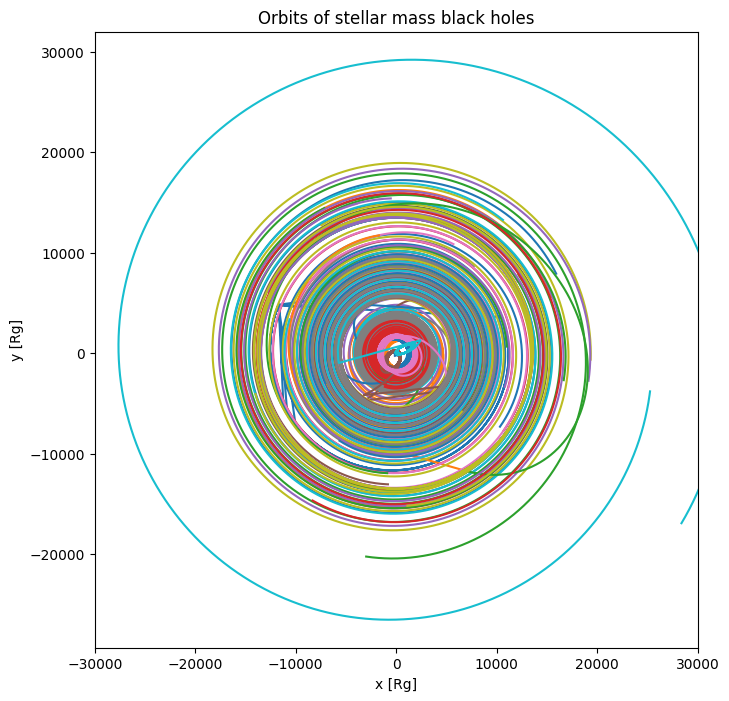

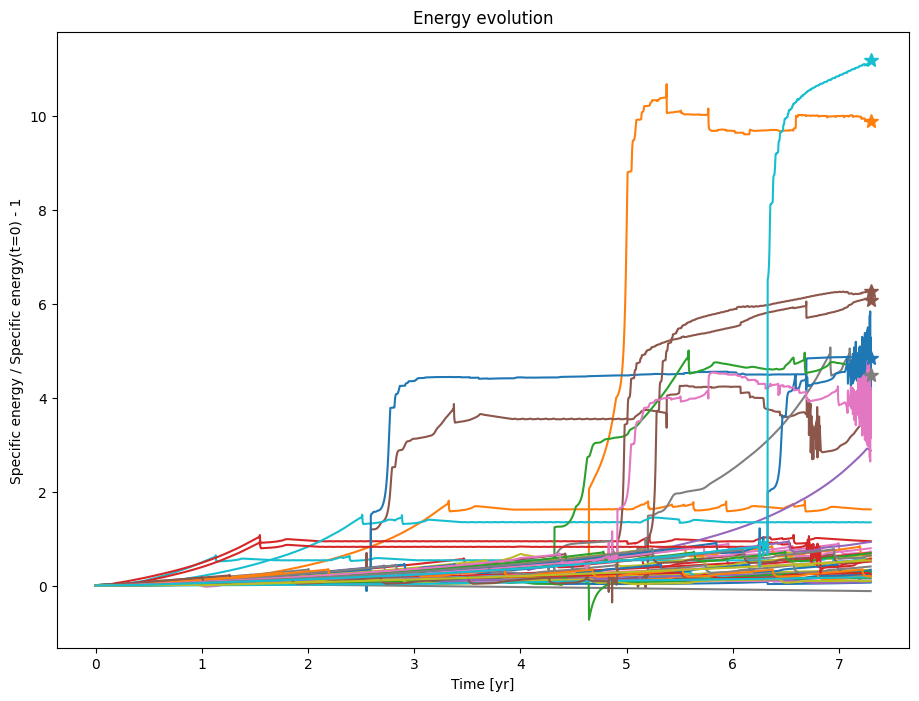

In [131]:
a = semi_major_axis(r,v)
P = period(r,v)
rr = np.sqrt(np.sum(pos**2,axis=0)).max(axis=1)
for i,a,rrr,p in zip(range(nbh),a,rr,P):
    print('P{:01}: a={:.0f} r={:.0f} Tend/P={:.1f}'.format(i,a,rrr,tend/p))

# make a simple plot of the orbits
plt.figure(figsize=(11,8))
plt.plot([0],[0], marker='*') # mark the SMBH

for i in range(nbh): # plot the orbits of the black holes
    plt.plot(pos[0,i],pos[1,i],label='bh{}'.format(i),color='C{}'.format(i))

plt.axis('scaled')
plt.xlabel('x [Rg]')
plt.ylabel('y [Rg]')
plt.xlim(-30000, 30000)
plt.title('Orbits of stellar mass black holes')
if nbh < 20:
    plt.legend()
plt.savefig('orbits_v4.png')

# Plot specific energy evolution for the particles
plt.figure(figsize = (11, 8))
E = specific_energy(pos, vel)
for i in range(nbh):
    plt.plot(tim*u.t/u.yr, E[i] / E[i,0]-1, label='bh{}'.format(i), color='C{}'.format(i))
plt.xlabel('Time [yr]')
plt.ylabel('Specific energy / Specific energy(t=0) - 1')
plt.title('Energy evolution')

# Marking the (detected) black holes that merged (20, 17, 32) with a star at the last timestep 
for i in [11, 17, 20, 25, 45, 49]:
    plt.plot(tim[-1]*u.t/u.yr, E[i][-1] / E[i,0]-1, marker = '*', color = 'C{}'.format(i), markersize = 10)
plt.savefig('energy_v4.png')

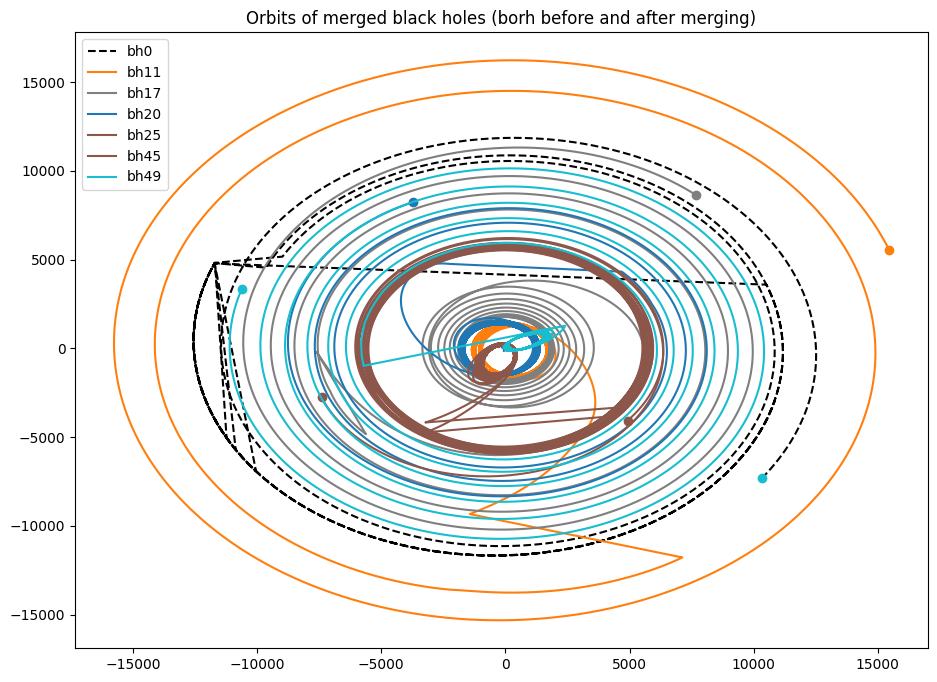

In [132]:
# Only plotting the black holes that merge 
plt.figure(figsize = (11,8))
plt.plot([0],[0], marker='*') # mark the SMBH

plt.plot(pos[0,0], pos[1,0],'--' ,label = 'bh0', color = 'black')
plt.plot(pos[0,0,0],pos[1,0,0], marker='o', color='C9')

# We know the following BHs merged: 20, 17, 32, 15 with other BHs
for i in [11, 17, 20, 25, 45, 49]:
    plt.plot(pos[0,i],pos[1,i],label='bh{}'.format(i),color='C{}'.format(i))
    # Marking the start position for each orbit 
    plt.plot(pos[0,i,0],pos[1,i,0], marker='o', color='C{}'.format(i))
plt.legend()
plt.title('Orbits of merged black holes (borh before and after merging)')
plt.savefig('orbits_merged.png')

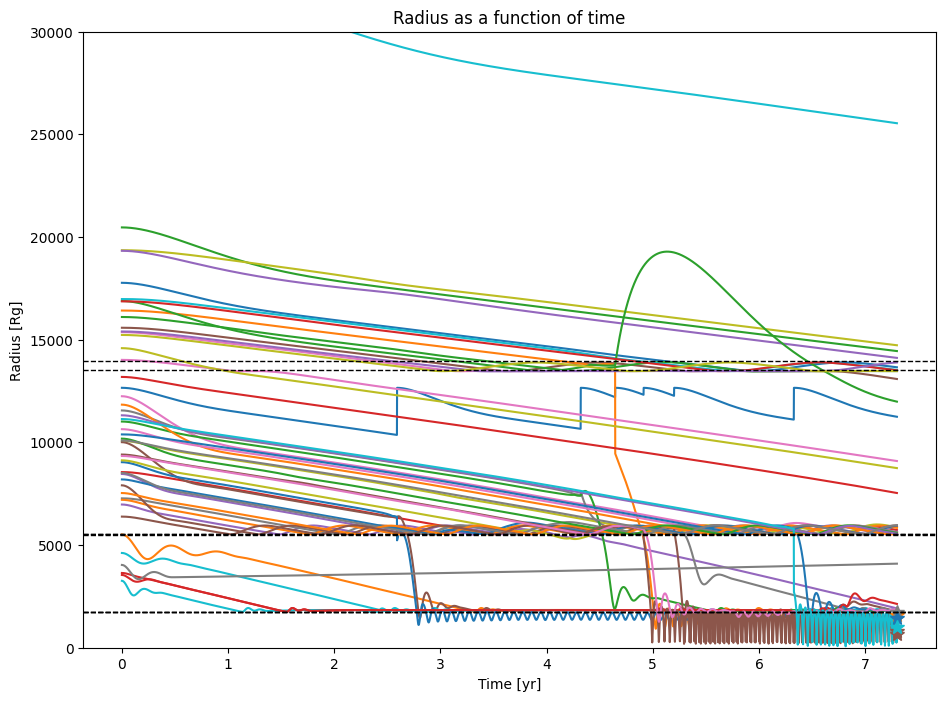

In [133]:
# Plotting the radius as a function of time
plt.figure(figsize = (11, 8))
for i in range(nbh):
    plt.plot(tim*u.t/u.yr, np.sqrt(np.sum(pos[:,i]**2, axis = 0)), label = 'bh{}'.format(i), color = 'C{}'.format(i))

# Marking the (detected) black holes that merged (20, 17, 32) with a star at the last timestep
for i in [11, 17, 20, 25, 45, 49]:
    plt.plot(tim[-1]*u.t/u.yr, np.sqrt(np.sum(pos[:,i,-1]**2)), marker = '*', color = 'C{}'.format(i), markersize = 10)

# Plotting R_trap over 
for i in R_trap:
    plt.axhline(i, color = 'black', linestyle = '--', linewidth = '1')

plt.ylim(0, 30000)
plt.xlabel('Time [yr]')
plt.ylabel('Radius [Rg]')
plt.title('Radius as a function of time')
plt.savefig('radius_v4.png')